In [6]:
import gspread
from oauth2client.service_account import ServiceAccountCredentials
import pandas as pd

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

In [8]:
credentials = ServiceAccountCredentials.from_json_keyfile_name(
    "../../../gckey.json",
    [
        "https://spreadsheets.google.com/feeds",
        "https://www.googleapis.com/auth/drive",
    ],
)
client = gspread.authorize(credentials)
spreadsheet = client.open("MaLA data mixing ablation")
Altruistic_Flores = spreadsheet.worksheet("Altruistic-Flores-200-X-Eng-BLEU")

In [9]:
Altruistic_Flores_Data = Altruistic_Flores.get_all_records(value_render_option="UNFORMATTED_VALUE")
df_Altruistic_Flores = pd.DataFrame(Altruistic_Flores_Data, columns=Altruistic_Flores_Data[0])

In [10]:
languages = ['zho_Hans-eng_Latn', 'ceb_Latn-eng_Latn', 'mar_Deva-eng_Latn', 'zul_Latn-eng_Latn', 'khm_Khmr-eng_Latn']
df_selected = df_Altruistic_Flores[['Model'] + languages]

In [11]:
df_long = df_selected.melt(id_vars='Model', var_name='Language', value_name='Score')

resource_map = {
    'zho_Hans-eng_Latn': 'High',
    'ceb_Latn-eng_Latn': 'Mid',
    'mar_Deva-eng_Latn': 'Mid',
    'zul_Latn-eng_Latn': 'Low',
    'khm_Khmr-eng_Latn': 'Low'
}
df_long['Resource_Level'] = df_long['Language'].map(resource_map)

In [12]:
def extract_base(model_name):
    if 'Llama-2-7B' in model_name:
        return 'Llama-2-7B'
    elif 'Llama-3.1-8B' in model_name:
        return 'Llama-3.1-8B'
    elif 'Viking-7B' in model_name:
        return 'Viking-7B'
    else:
        return 'Other'
    
def extract_data_combination(model_name):
    if 'Bilingual-Code' in model_name:
        return 'Bilingual-Code'
    elif 'Bilingual' in model_name:
        return 'Bilingual'
    elif 'Monolingual-Code' in model_name:
        return 'Monolingual-Code'
    elif 'Monolingual' in model_name:
        return 'Monolingual'
    else:
        return 'Unknown'

df_long['Base_Model'] = df_long['Model'].apply(extract_base)
df_long['Data_Combination'] = df_long['Model'].apply(extract_data_combination)

In [13]:
df_agg = df_long.groupby(['Base_Model','Data_Combination','Resource_Level'], as_index=False)['Score'].mean()

data_combination_order = ['Bilingual', 'Bilingual-Code', 'Monolingual', 'Monolingual-Code']
resource_order = ['High','Mid','Low']
base_model_order = ['Llama-2-7B','Llama-3.1-8B','Viking-7B']

df_agg['Data_Combination'] = pd.Categorical(df_agg['Data_Combination'], categories=data_combination_order, ordered=True)
df_agg['Resource_Level'] = pd.Categorical(df_agg['Resource_Level'], categories=resource_order, ordered=True)

In [14]:
df_agg

,Base_Model,Data_Combination,Resource_Level,Score
0,Llama-2-7B,Bilingual,High,18.350371
1,Llama-2-7B,Bilingual,Low,16.268745
2,Llama-2-7B,Bilingual,Mid,23.488472
3,Llama-2-7B,Bilingual-Code,High,13.031056
4,Llama-2-7B,Bilingual-Code,Low,4.950766
5,Llama-2-7B,Bilingual-Code,Mid,8.255188
6,Llama-2-7B,Monolingual,High,16.850501
7,Llama-2-7B,Monolingual,Low,15.522624
8,Llama-2-7B,Monolingual,Mid,22.991202
9,Llama-2-7B,Monolingual-Code,High,17.967803


/tmp/ipykernel_2978584/2387441553.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  lineplot = sns.lineplot(


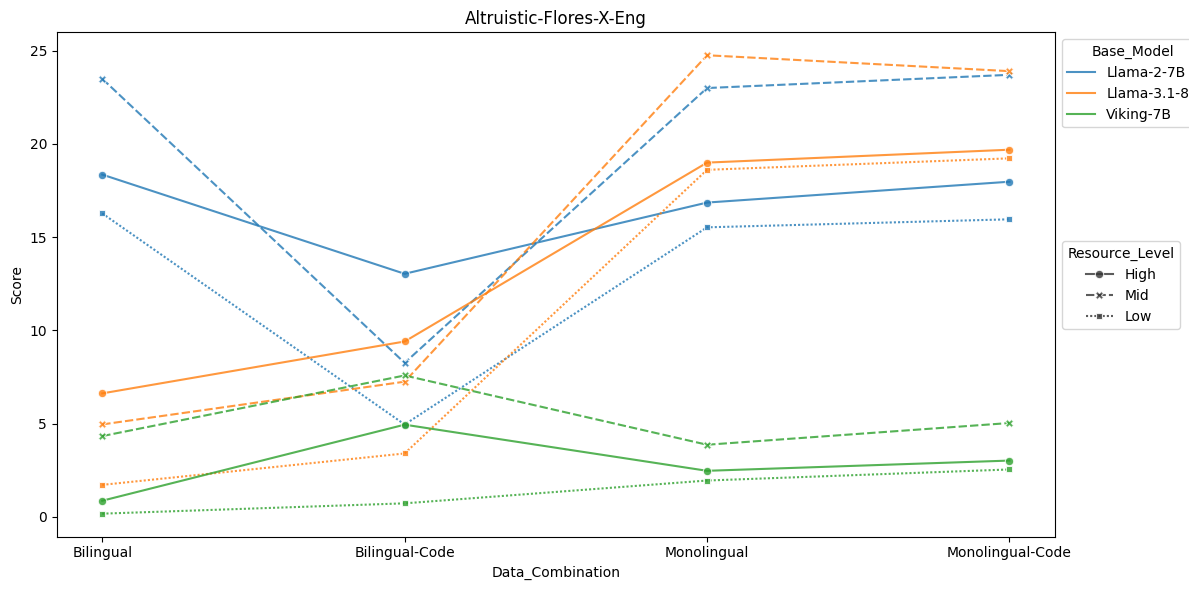

In [15]:
plt.figure(figsize=(12,6))
lineplot = sns.lineplot(
    data=df_agg,
    x='Data_Combination',
    y='Score',
    hue='Base_Model',        
    style='Resource_Level',  
    markers=True,
    dashes=True,
    ci=None,
    hue_order=base_model_order,
    style_order=resource_order,
    linewidth=1.5,      # 细一些的线条
    alpha=0.8            # 线条有一定透明度
)

plt.title('Altruistic-Flores-X-Eng')
plt.xticks(rotation=0)

# 获取图例句柄和标签
handles, labels = lineplot.get_legend_handles_labels()

# 分离Base_Model和Resource_Level的legend项
base_handles = []
base_labels = []
style_handles = []
style_labels = []

for handle, label in zip(handles, labels):
    if label in base_model_order:
        base_handles.append(handle)
        base_labels.append(label)
    elif label in resource_order:
        style_handles.append(handle)
        style_labels.append(label)

# 移除默认图例
lineplot.legend_.remove()

plt.subplots_adjust(right=0.7)

# 添加Base_Model图例在右侧
legend_base = plt.legend(
    base_handles, base_labels, 
    title='Base_Model', 
    bbox_to_anchor=(1.0, 1),  # 移到图外右侧
    loc='upper left'
)
plt.gca().add_artist(legend_base)

# 添加Resource_Level图例在右侧下方
plt.legend(
    style_handles, style_labels, 
    title='Resource_Level',
    bbox_to_anchor=(1.0, 0.6),  # 在右侧稍微下方的位置
    loc='upper left'
)


plt.tight_layout()
plt.show()